# What are the most demanded skills for Data Analyst?

*Methodology*

1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skills percentage
4. Plot final findings


## Import Libraries and Data

In [5]:
# Import Libraries
import numpy as np
import pandas as pd
from datasets import load_dataset 
import matplotlib.pyplot as plt
import ast
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

## Filter Data and Remove Duplicates

Filter the data for the italian market and/or for the data analyst position. Remove reposted jobs for the same position from the same company.

In [6]:
df_it = df[df['job_country']=='Italy'].drop_duplicates(subset=["job_title","company_name"]).copy()
df_DA = df[df['job_title_short']=='Data Analyst'].drop_duplicates(subset=["job_title","company_name"]).copy()
df_DA_it = df[(df['job_title_short']=='Data Analyst') & (df['job_country']=='Italy')].drop_duplicates(subset=["job_title","company_name"]).copy()

## Explode Skills

Converts the `job_skills` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the `job_title` and `job_skills` columns, allowing us to analyze the distribution of skills across different data job titles.

In [7]:
df_it['job_skills'] = df_it['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)
df_it_exploded= df_it.explode('job_skills').copy()
df_it_exploded[['job_title','job_skills']]

,job_title,job_skills
46,"Data Analyst (Bangkok Based, relocation provided)",sas
46,"Data Analyst (Bangkok Based, relocation provided)",sas
46,"Data Analyst (Bangkok Based, relocation provided)",r
46,"Data Analyst (Bangkok Based, relocation provided)",python
46,"Data Analyst (Bangkok Based, relocation provided)",vba
...,...,...
785527,Bi Specialist,dax
785573,DATA SPECIALIST FRONT END,sql
785573,DATA SPECIALIST FRONT END,html
785573,DATA SPECIALIST FRONT END,css


## Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.

In [8]:
skills_count = df_it_exploded.groupby(['job_title_short','job_skills']).size()
# skill_count is now a series, to transform into a dataframe just add new indexes and the old ones becomes a new column named skill_count
df_skills_count = skills_count.reset_index(name='skill_count')
df_skills_count = df_skills_count.sort_values(by='skill_count', ascending=False)
df_skills_count

,job_title_short,job_skills,skill_count
659,Data Scientist,python,1648
528,Data Engineer,sql,1146
502,Data Engineer,python,1126
279,Data Analyst,excel,1090
685,Data Scientist,sql,1012
...,...,...,...
789,Machine Learning Engineer,react,1
141,Cloud Engineer,confluence,1
993,Senior Data Engineer,sharepoint,1
678,Data Scientist,slack,1


## Focus: Top 10 skills for Data Analyst

Filter the job titles yo have only Data Analyst postings

In [9]:
# Visualize top 10 for Data Analyst

job_title='Data Analyst'
top_skills=10

df_final_skill = df_skills_count[df_skills_count['job_title_short']==job_title].head(top_skills).reset_index()

df_final_skill

,index,job_title_short,job_skills,skill_count
0,279,Data Analyst,excel,1090
1,366,Data Analyst,sql,883
2,340,Data Analyst,python,667
3,334,Data Analyst,power bi,449
4,350,Data Analyst,sas,376
5,373,Data Analyst,tableau,366
6,343,Data Analyst,r,344
7,287,Data Analyst,gdpr,253
8,349,Data Analyst,sap,206
9,342,Data Analyst,qlik,149


## Focus: How much are my skills in demand?

Create a list containing the name of the skills I already know. Create a list of colors for the plot, in which a color is associated to each skill.

In [10]:
my_skills=['excel','python','sql','r','tableau']

# Highlight my skills in royalblue against silver 
cols = ['silver'] * top_skills
highlight_indices = df_final_skill[df_final_skill['job_skills'].isin(my_skills)].index.tolist()
for idx in highlight_indices:
    cols[idx] = 'royalblue' 

## Plot Skill Counts

Create a stacked horizontal bar chart for the top 10 skills for Data Analyst, displaying the frequency of each skill. Color highlights the skills I already know.

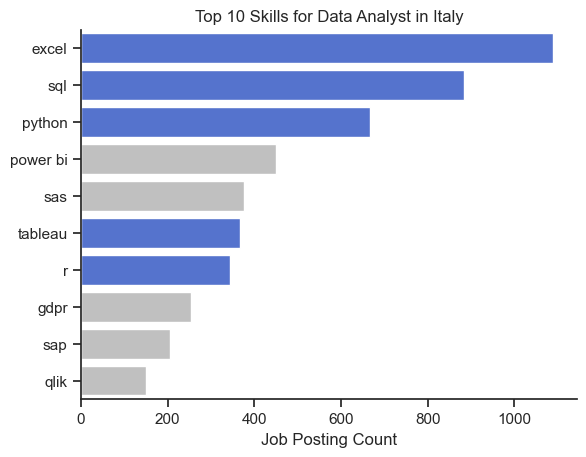

In [11]:
# horizontal bar plot
sns.set_theme(style='ticks')
#df_final_skill.plot(kind='barh',x='job_skills',y='skill_count',color=cols)
sns.barplot(data=df_final_skill, x='skill_count',y='job_skills',hue='job_skills',palette=cols,legend=False)
sns.despine()
# add title, change labels
plt.title(f"Top {top_skills} Skills for {job_title} in Italy")
plt.xlabel('Job Posting Count')
plt.ylabel('')
plt.show()

## Create List of Top 3 Roles 

Filter the job titles based on the most popular.

In [12]:
top_jobs = 3

job_titles = df_skills_count['job_title_short'].unique()[:top_jobs].tolist()
job_titles = sorted(job_titles)
job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Convert Counts to Percentages
### Focus: Counts don't show what portions of jobs are requesting these skills

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the `value_counts()` method on the `job_title_short` column. Then reset the index to transform the Series into a DataFrame and renames the columns to `job_title_short` and `total`. The DataFrame `df_job_total_count` now holds a list of job titles alongside their total occurrences.



In [13]:
# Use original df to get the count of job titles
df_job_total_count = df_it['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_total_count

,job_title_short,jobs_total
0,Data Analyst,2910
1,Data Scientist,2595
2,Data Engineer,2054
3,Software Engineer,1037
4,Business Analyst,965
5,Cloud Engineer,333
6,Senior Data Scientist,306
7,Machine Learning Engineer,264
8,Senior Data Engineer,255
9,Senior Data Analyst,203


Then we calculate the percentages. First merge `df_skills_count` and `df_job_total_count`, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [14]:
df_skill_perc = pd.merge(df_skills_count,df_job_total_count, how='left',on='job_title_short')
df_skill_perc['skill_percent'] = 100 * df_skill_perc['skill_count']/df_skill_perc['jobs_total']  
df_skill_perc

,job_title_short,job_skills,skill_count,jobs_total,skill_percent
0,Data Scientist,python,1648,2595,63.506744
1,Data Engineer,sql,1146,2054,55.793574
2,Data Engineer,python,1126,2054,54.819864
3,Data Analyst,excel,1090,2910,37.457045
4,Data Scientist,sql,1012,2595,38.998073
...,...,...,...,...,...
1299,Machine Learning Engineer,react,1,264,0.378788
1300,Cloud Engineer,confluence,1,333,0.300300
1301,Senior Data Engineer,sharepoint,1,255,0.392157
1302,Data Scientist,slack,1,2595,0.038536


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom. Highlight as before the skills I already know.

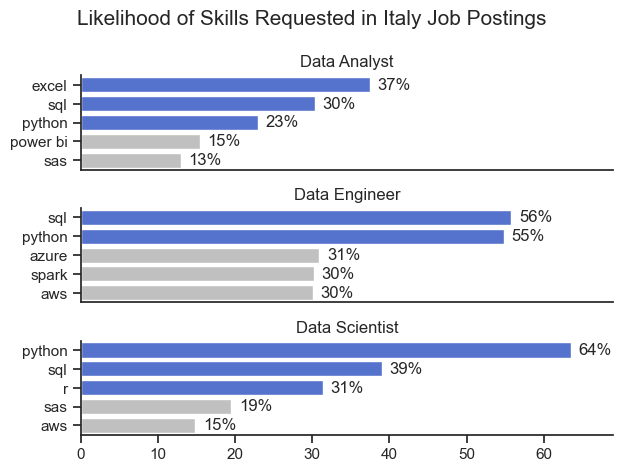

In [15]:
fig, ax = plt.subplots(len(job_titles),1)
sns.set_theme(style='ticks')

top_skills = 5

for i,job_title in enumerate(job_titles):
    df_plot = df_skill_perc[df_skill_perc['job_title_short']==job_title].head(top_skills).reset_index()
    cols = ['silver']*top_skills
    highlight_indices = df_plot[df_plot['job_skills'].isin(my_skills)].index.tolist()
    for idx in highlight_indices:
        cols[idx] = 'royalblue' 
    sns.barplot(data=df_plot,x='skill_percent',y='job_skills',ax=ax[i],hue='job_skills',palette=cols,legend=False)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xlim(0,69)
    ax[i].set_title(job_title)
    sns.despine()

    for n,v in enumerate(df_plot['skill_percent']):
        ax[i].text(v+1,n,f'{v:.0f}%', va='center') 

    if i!=len(job_titles)-1:
        ax[i].set_xticks([])

fig.suptitle('Likelihood of Skills Requested in Italy Job Postings', fontsize=15)
fig.tight_layout()
plt.show()